# Quark Gluon Classification

## Import libraries

In [1]:
from configs import *
import pyarrow.parquet as pq
from livelossplot import PlotLossesKeras
import pandas as pd
import numpy as np
import h5py

## Data preparation, compression and preprocessing

As the dataframes obtained from the parquet files take up most of the memory, we must optimize our I/O by separating compute and storage. We do this by iterating through each row of every parquet file using [pyarrow](https://arrow.apache.org/docs/python/index.html) and creating .hdf5 files consisting of (image, label) pairs on our disk for each of the training, validation and testing splits respectively. We can then define a custom HDF5 data generator as defined in [configs.py](configs.py) to stream the data in batches from our disk to our GPU(where the model resides), thus reducing the memory footprint of our training process. Additionally, the images are not stored in their original size of 125x125x3, but are instead cropped to 33x33x33 using a center crop, summing the pixel values of the 3 channels (described in [this workshop presentation](https://indico.cern.ch/event/661284/contributions/2699312/attachments/1521324/2376721/ML_Workshop.pdf)) and then normalizing the image by dividing it by the square root of the sum of squares of the image(equalization).  This is done to reduce the training time and memory footprint of our model, while also giving us the opportunity to increase the throughput of our model by using a larger batch size. This is because the images are now smaller and thus can be processed faster by the GPU. It also makes our pipeline a potentially effective one when it comes to deploying our model on a real-time application.

In [2]:
num_of_samples = 0
for file in os.listdir('./data'):
    if file.endswith('.parquet'):
        parquet_file = pq.ParquetFile('./data/' + file)
        num_of_samples += parquet_file.metadata.num_rows
print('Number of samples: {}'.format(num_of_samples))

Number of samples: 139306


In [3]:
train_samples = int(num_of_samples * 0.95)
val_samples = ceil(num_of_samples * 0.025)
test_samples = num_of_samples - train_samples - val_samples
print('Number of train samples: {}'.format(train_samples))
print('Number of validation samples: {}'.format(val_samples))
print('Number of test samples: {}'.format(test_samples))

Number of train samples: 132340
Number of validation samples: 3483
Number of test samples: 3483


In [4]:
paqruet_files = os.listdir(data_dir)
train_file = h5py.File(data_dir+'/'+'train.hdf5', 'w')
val_file = h5py.File(data_dir+'/'+'val.hdf5', 'w')
test_file = h5py.File(data_dir+'/'+'test.hdf5', 'w')

train_split, val_split, test_split = train_samples, val_samples, test_samples
current_train, current_val, current_test = 0, 0, 0

train_images, train_labels = train_file.create_dataset(
    'images', 
    (train_split,33,33,1), 
    dtype='f4'
),  train_file.create_dataset(
    'labels', 
    (train_split,), 
    dtype='f4'
)
val_images, val_labels = val_file.create_dataset(
    'images', 
    (val_split,33,33,1), 
    dtype='f4'
),  val_file.create_dataset(
    'labels', 
    (val_split,), 
    dtype='f4'
)
test_images, test_labels = test_file.create_dataset(
    'images', 
    (test_split,33,33,1), 
    dtype='f4'
),  test_file.create_dataset(
    'labels', 
    (test_split,), 
    dtype='f4'
)

for file in paqruet_files:
    if file.endswith('.parquet'):
        parquet_dir = data_dir + '/' + file
        parquet_file = pq.ParquetFile(parquet_dir)
        num_rows = parquet_file.metadata.num_rows
        print('parsing file : {}'.format(file))
        for i in range(num_rows):
            df = parquet_file.read_row_group(i).to_pandas()
            y = df['y'].values[0]
            nested_array = df['X_jets'].values[0]
            channel_1 = np.array(list(nested_array[0]))
            channel_2 = np.array(list(nested_array[1]))
            channel_3 = np.array(list(nested_array[2]))
            image = np.stack((channel_1, channel_2, channel_3), axis=-1)
            image = center_crop(image, 33, 33)
            image = image.astype(np.float32)
            image = np.sum(image, axis=2, keepdims=True)
            sum_of_squares = np.sum(image**2)
            sqrt_sum_of_squares = np.sqrt(sum_of_squares)
            image = image / sqrt_sum_of_squares

            if current_train < train_split:
                train_images[current_train] = image
                train_labels[current_train] = y
                current_train += 1
            elif current_val < val_split:
                val_images[current_val] = image
                val_labels[current_val] = y 
                current_val += 1
            elif current_test < test_split:
                test_images[current_test] = image
                test_labels[current_test] = y
                current_test += 1

train_file.close()
val_file.close()
test_file.close()    

parsing file : QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet
parsing file : QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet
parsing file : QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet


## Define model

In [5]:
def get_tflow_model(input_shape=(33,33,1)):
    
  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  return model 

model = get_tflow_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 31, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 6, 6, 64)          0

## EDA on labels

### A quick look at the distribution of labels reveals a reasonably balanced training set.

In [3]:
train_file = h5py.File(data_dir+'/train.hdf5', 'r')
train_labels = np.array(train_file['labels'])
labels = {0:0, 1:0}
for label in train_labels:
    labels[label] += 1
print(labels[0], labels[1])
train_file.close()

66147 66193


## Train model

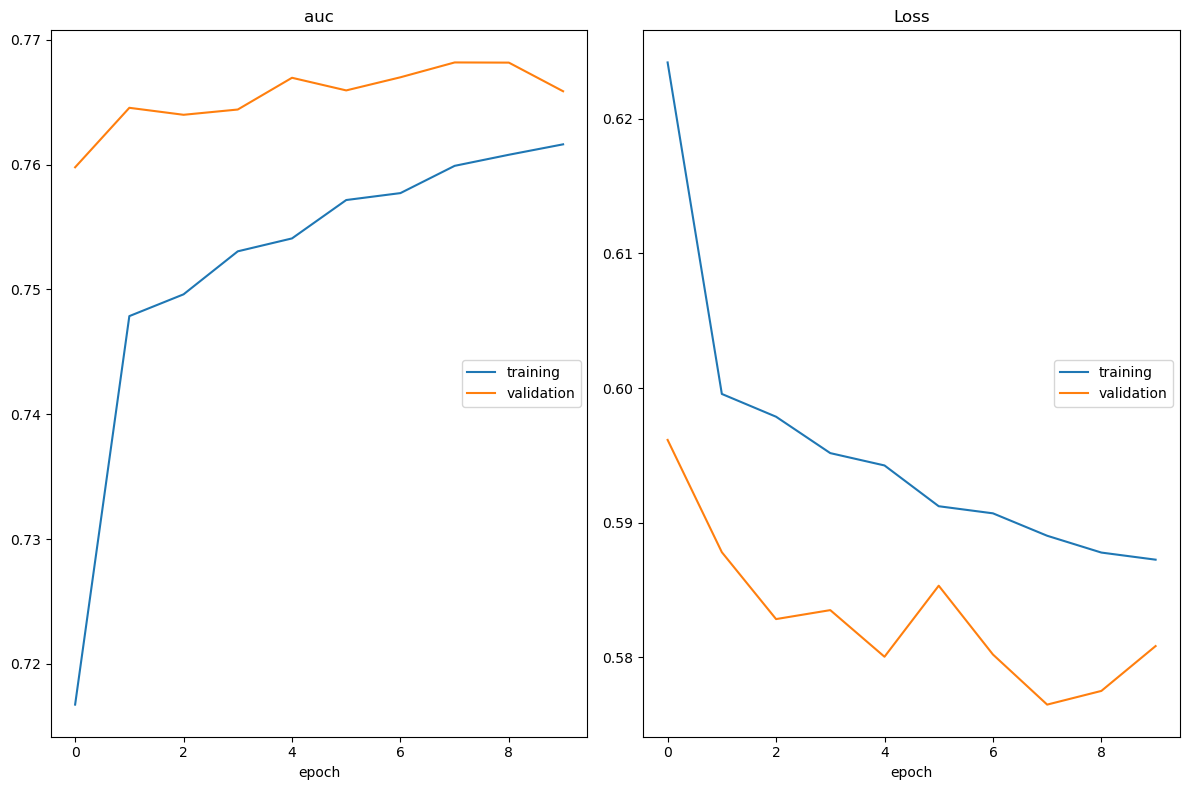

auc
	training         	 (min:    0.717, max:    0.762, cur:    0.762)
	validation       	 (min:    0.760, max:    0.768, cur:    0.766)
Loss
	training         	 (min:    0.587, max:    0.624, cur:    0.587)
	validation       	 (min:    0.576, max:    0.596, cur:    0.581)

Epoch 10: val_auc did not improve from 0.76818
2068/2068 [==============================] - 23s 11ms/step - loss: 0.5873 - auc: 0.7616 - val_loss: 0.5808 - val_auc: 0.7659


In [3]:
train_file = h5py.File(data_dir+'/train.hdf5', 'r')
val_file = h5py.File(data_dir+'/val.hdf5', 'r')
train_generator = HDF5ImageGenerator(
    hdf5_x = train_file['images'],
    hdf5_y = train_file['labels'],
    batch_size = batch_size
)
val_generator = HDF5ImageGenerator(
    hdf5_x = val_file['images'],
    hdf5_y = val_file['labels'],
    batch_size = batch_size,
    mode = 'val'
)
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.AUC()]
)
#lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
ckpt = tf.keras.callbacks.ModelCheckpoint(
    weights_dir,
    monitor='val_auc',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch'
)
model.fit(
    train_generator,
    epochs = epochs,
    steps_per_epoch = train_samples//batch_size+1,
    validation_data=val_generator,
    validation_steps = val_samples//batch_size+1,
    callbacks=[PlotLossesKeras(), ckpt],
    verbose=1
)
train_file.close()
val_file.close()

## Plot Results on Test Set

### We are able to achieve satisfactory results on the test set with a relatively small model size and limited spatial information which speaks to the efficiency of this approach. Different model architectures, preprocessing techniques and hyperparameters can be explored to further improve the performance of our model.

109/109 [==============================] - 6s 3ms/step


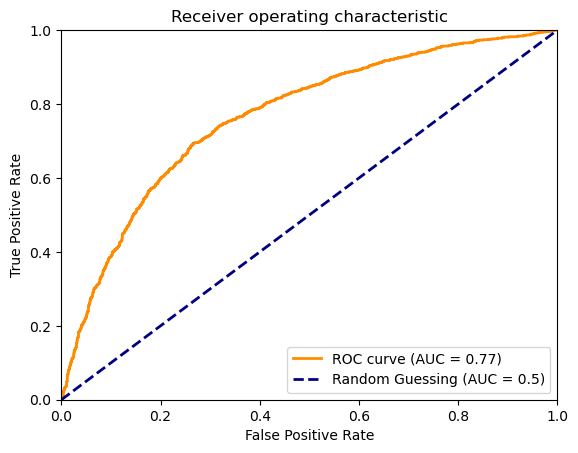

Accuracy: 0.7131782945736435


In [6]:
test_file = h5py.File(data_dir+'/test.hdf5', 'r')
test_images = np.array(test_file['images'])
test_labels = np.array(test_file['labels'])
model.load_weights(weights_dir)
predictions = model.predict(test_images)
plot_ROC_AUC(test_labels, predictions)
print('Accuracy: {}'.format(accuracy_score(test_labels, np.round(predictions))))